Training Step: 3829  | total loss: 0.43229 | time: 81.589s
| Adam | epoch: 010 | loss: 0.43229 - acc: 0.8105 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.43053 | time: 82.812s
| Adam | epoch: 010 | loss: 0.43053 - acc: 0.8060 | val_loss: 0.51964 - val_acc: 0.7680 -- iter: 24500/24500
--


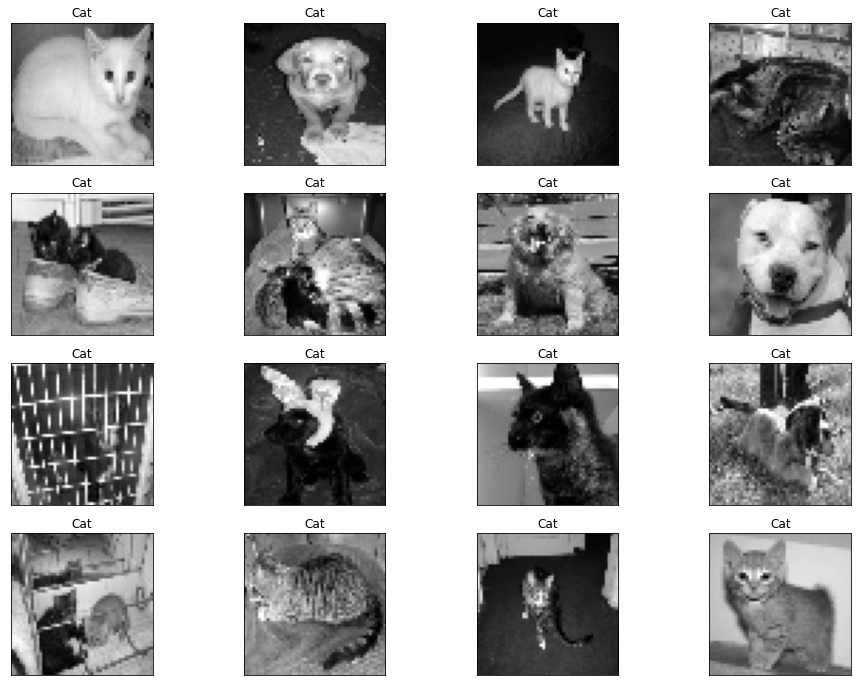

In [2]:
import cv2
import numpy as np
from random import shuffle
import os
from tqdm import tqdm
import tensorflow  as tf
import matplotlib.pyplot as plt
import tflearn
from tflearn.layers.conv import conv_2d ,max_pool_2d
from tflearn.layers.core import input_data ,dropout,fully_connected
from tflearn.layers.estimator import regression
%matplotlib inline
TRAIN_DIR = 'train'
TEST_DIR = 'test1'
IMG_SIZE = 50
LR = 1e-3
MODEL_NAME = 'doges_vs_cats_convnet'
def create_label(image_name):
    """Create an one_hot encoded vector from image name"""
    word_label = image_name.split('.')[-3]
    if word_label=='cat':
        return np.array([1,0])
    elif word_label=='dog':
        return np.array([0,1])
def create_train_data():
    training_data  = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        path = os.path.join(TRAIN_DIR, img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data,(IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img_data), create_label(img)])
    shuffle(training_data)
    np.save('training_data.npy', training_data)
    return training_data

def create_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img_data = cv2.imread(path ,cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data,(IMG_SIZE ,IMG_SIZE))
        testing_data.append([np.array(img_data),img_num])

    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

# if dataset is not created
train_data = create_train_data()
test_data = create_test_data()
# If you have already created the dataset:
# train_data = np.load('train_data.py')
#  test_data = np.load('test_data.py')
train = train_data[:-500]
test =  train_data[-500:]
x_train = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE, IMG_SIZE , 1)
y_train = [i[1] for i in train]
x_test = np.array([i[0] for i in test]).reshape(-1 ,IMG_SIZE ,IMG_SIZE,1)
y_test = [i[1] for i in test]
# Building the model
tf.reset_default_graph()
convnet = input_data(shape=[None ,IMG_SIZE ,IMG_SIZE ,1], name = 'input')
convnet = conv_2d(convnet, 32 ,5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64 ,5, activation='relu')
convnet = max_pool_2d(convnet,5)
convnet = conv_2d(convnet,128 ,5, activation='relu')
convnet = max_pool_2d(convnet,5)
convnet = conv_2d(convnet, 64 ,5, activation='relu')
convnet = max_pool_2d(convnet,5)
convnet = conv_2d(convnet, 32 ,5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = fully_connected(convnet , 1024 ,activation='relu')
convnet = dropout(convnet ,0.8)
convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet , optimizer= 'adam' , learning_rate=LR, loss= 'categorical_crossentropy',name='targets')
model = tflearn.DNN(convnet , tensorboard_dir='log' ,tensorboard_verbose=0)
model.fit({'input':x_train} ,{'targets':y_train} ,n_epoch=10,
          validation_set=({'input':x_test},{'targets':y_test}),
          snapshot_step=500 ,show_metric= True ,run_id=MODEL_NAME)

fig = plt.figure(figsize=(16, 12))

for num , data in enumerate(test_data[:16]):

    img_num = data[1]
    img_data = data[0]

    y = fig.add_subplot(4, 4, num +1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE ,IMG_SIZE ,1)
    model_out = model.predict([data])[0]

    if np.argmax(model_out==1):
        str_label = 'Dog'
    else:
        str_label = 'Cat'
    y.imshow(orig ,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()